In [1]:
import copy
import torch
import numpy as np
import pandas as pd
import time
import tqdm
import matplotlib.pyplot as plt
import scipy.stats

from training_utils.file_utils import (open_json, write_json, save_submission,
                                       log_kfold_training, log_learning_curve)
from training_utils.models import HybridNN
from training_utils.model_utils import *
from training_utils.training import k_fold_training


In [2]:
TRAINING_DIR = "outputs/hybrid_0/"

config = open_json(TRAINING_DIR+"config.json")

features = open_json(TRAINING_DIR+"features.json")
models, _ = load_models_and_scalers(TRAINING_DIR)


In [3]:
def compute_feature_weight(model):
    weights =  []
    for name, params in model.named_parameters():
        if "regression_model" in name and "weight" in name:
            weights.append(params.cpu().detach().numpy())

    summed_weights = np.array([1])
    for params in reversed(weights):
        params = np.multiply(summed_weights, params)
        summed_weights = abs(params).sum(axis=0)
        summed_weights = summed_weights.reshape(summed_weights.shape[0], 1)
    
    return summed_weights


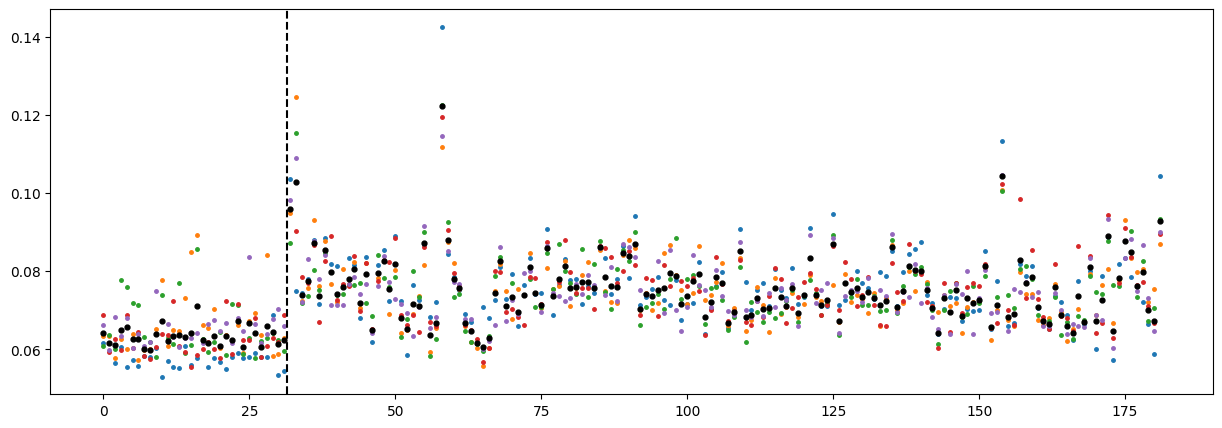

In [4]:
_ =  plt.figure(figsize=(15,5))
all_summed_weights = []
for model in models:
    summed_weights = compute_feature_weight(model)
    summed_weights = summed_weights/np.linalg.norm(summed_weights)
    all_summed_weights.append(summed_weights)
    plt.plot(summed_weights, '.', markersize=5)

avg_summed_weights = np.array(all_summed_weights).mean(axis=0)
plt.plot(avg_summed_weights, 'k.', markersize=7)
plt.axvline(config["cnn_dense_layer_size"]-0.5, color="k", linestyle="--")



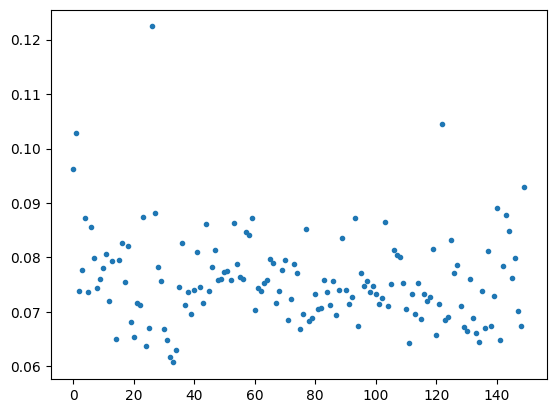

In [5]:
normalized_weights = avg_summed_weights[config["cnn_dense_layer_size"]:]/np.linalg.norm(avg_summed_weights)
feature_weights = [[features[i], weight[0]]
                   for i, weight in enumerate(normalized_weights)]
feature_weights.sort(key=lambda x: x[1], reverse=True)

plt.plot(normalized_weights, ".")

write_json(TRAINING_DIR+"feature_weights.json", dict(feature_weights))